Importing required modules

In [200]:
#Linear algebra and processing 
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, classification_report

import re
import pickle
import os

#data visualisation 
import warnings
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

Setting directory variables

In [201]:
input_data_dir = r"C:\Users\91738\OneDrive\Desktop\Accredian\inputs"
output_data_dir = r"C:\Users\91738\OneDrive\Desktop\Accredian\outputs"
models_dir = r"C:\Users\91738\OneDrive\Desktop\Accredian\models"

Loading data

In [202]:
if not os.path.exists(output_data_dir):
    os.makedirs(output_data_dir)
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

    
def load_data(data_dir, file_name):
    """
    Load data from a CSV file and parse date columns.

    Parameters:
        data_dir (str): The directory where the data file is located.
        file_name (str): The name of the CSV file to load.

    Returns:
        pd.DataFrame: The loaded dataset.
    """
    file_path = os.path.join(data_dir, file_name)
    return pd.read_csv(file_path)

In [203]:
data = load_data(input_data_dir, "Fraud.csv")

Data inspection 

In [204]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Data summary statistics

In [205]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [206]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Pre EDA data processing 

- Duplicate data processing 

In [207]:
data.duplicated().value_counts() #no need to process - no duplicates

False    6362620
dtype: int64

- Null value processing

In [208]:
data.isnull().sum() #no null values 

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

EDA

Post EDA data processing 

- Dropping redundant columns 

In [209]:
def calculate_uniqueness_ratio(dataset):
    """
    Calculate the uniqueness ratio for each column in the dataset.

    Parameters:
    dataset (pd.DataFrame): The dataset to calculate uniqueness ratios for.

    Returns:
    dict: A dictionary where keys are column names and values are uniqueness ratios.
    """
    # Select object-type columns
    object_columns = dataset.select_dtypes(include='object').columns

    # Calculate uniqueness ratios
    uniqueness_ratios = {column: len(dataset[column].unique()) / len(dataset)
                         for column in object_columns}

    return uniqueness_ratios

def display_uniqueness_ratios(uniqueness_ratios):
    """
    Display the uniqueness ratios.

    Parameters:
    uniqueness_ratios (dict): A dictionary containing column names and uniqueness ratios.
    """
    print("Uniqueness ratios:\n")
    for column_name, ratio in uniqueness_ratios.items():
        print(f"{column_name}: {ratio}")

In [210]:
uniqueness_ratios = calculate_uniqueness_ratio(data)
display_uniqueness_ratios(uniqueness_ratios)

Uniqueness ratios:

type: 7.858397955559188e-07
nameOrig: 0.9985362947967975
nameDest: 0.4278680795018404


In [211]:
"""
As observed, the 'nameOrig' and 'nameDest' columns exhibit a high uniqueness ratio, 
indicating no variation and no correlation. Therefore, it is appropriate to drop these columns.
"""
data.drop(columns=["nameOrig","nameDest"], inplace=True)

- Encoding categorical data

In [212]:
encoder = LabelEncoder()

In [213]:
data.type = encoder.fit_transform(data.type)

In [214]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0


- Outlier analysis

In [215]:
def detect_outliers(column):
    """
    Detect outliers in a numerical column using the IQR method.

    Parameters:
    column (pd.Series): A numerical column.

    Returns:
    pd.Series: A boolean series indicating outliers.
    """
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((column < lower_bound) | (column > upper_bound)).sum()

def calculate_outlier_ratio(dataset):
    """
    Calculate the outlier ratio for each numerical column in the dataset using the IQR method.

    Parameters:
    dataset (pd.DataFrame): The dataset.

    Returns:
    dict: A dictionary where keys are column names and values are outlier ratios.
    """
    numerical_columns = dataset.select_dtypes(include='float').columns
    outlier_ratios = {}

    for column in numerical_columns:
        outliers = detect_outliers(dataset[column])
        outlier_ratio = outliers/len(dataset)
        outlier_ratios[column] = outlier_ratio

    return outlier_ratios

def display_outlier_ratios(outlier_ratios):
    """
    Display the outlier ratios.

    Parameters:
    outlier_ratios (dict): A dictionary containing column names and outlier ratios.
    """
    print("Outlier ratios:\n")
    for column_name, ratio in outlier_ratios.items():
        ratio = np.round(ratio*100,3)
        print(f"{column_name}: {ratio}%")

In [216]:
"""
I believe outliers are important for this particular problem statement, as they can potentially signify fraudulent activities.
Therefore, I will retain and utilize the outliers in my analysis and model building process.
"""
outlier_ratios = calculate_outlier_ratio(data) 
display_outlier_ratios(outlier_ratios)

Outlier ratios:

amount: 5.314%
oldbalanceOrg: 17.485%
newbalanceOrig: 16.556%
oldbalanceDest: 12.356%
newbalanceDest: 11.607%


- Scaling data

In [217]:
scaling_columns = data.select_dtypes(include='float').columns

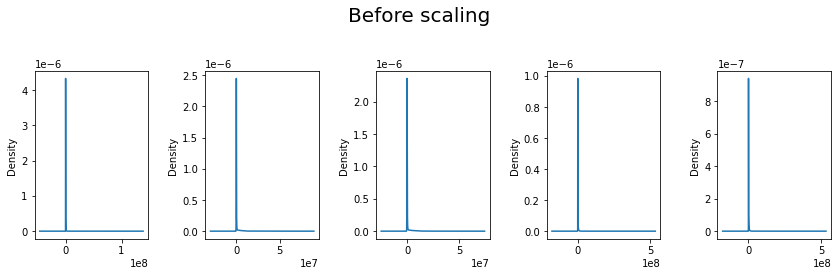

In [218]:
plt.figure(figsize=(12,4))
plt.suptitle("Before scaling",fontsize=20)
for i in range(len(scaling_columns)):
    plt.subplot(1,5,i+1)
    data[scaling_columns[i]].plot(kind="kde")    
plt.tight_layout(pad=2)
plt.show()

In [219]:
def scale_data(data, columns=scaling_columns):
    """
    Scale specified columns of the dataset using different scalers.

    Parameters:
    data (pd.DataFrame): The dataset to be scaled.
    columns (list, optional): List of column names to be scaled. If not provided, all columns are scaled.

    Returns:
    pd.DataFrame: The scaled dataset.
    """
    # If columns are not provided, scale all columns
    if columns is None:
        columns = data.select_dtypes(include='float').columns
    
    scalers = [('StandardScaler', StandardScaler()),
               ('MinMaxScaler', MinMaxScaler()),
               ('RobustScaler', RobustScaler()),
               ('PowerTransformer', PowerTransformer(method='yeo-johnson'))
              ]
    
    scaler_pipeline = Pipeline(scalers)
    data[columns] = scaler_pipeline.fit_transform(data[columns])
    return data

In [220]:
scaled_data = scale_data(data)

In [221]:
scaled_data_path = os.path.join(output_data_dir, "scaled_data.pkl")
with open(scaled_data_path, "wb") as file:
        pickle.dump(scaled_data, file)

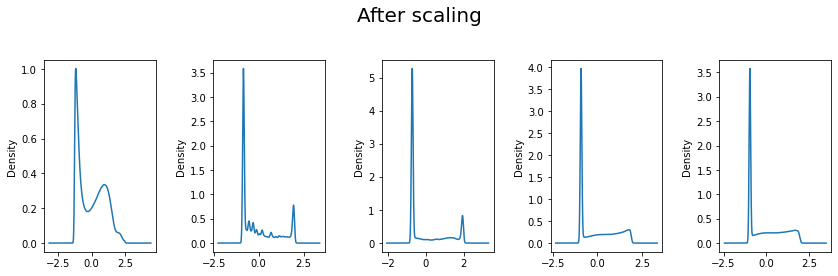

In [222]:
plt.figure(figsize=(12,4))
plt.suptitle("After scaling",fontsize=20)
for i in range(len(scaling_columns)):
    plt.subplot(1,5,i+1)
    scaled_data[scaling_columns[i]].plot(kind="kde")    
plt.tight_layout(pad=2)
plt.show()

In [3]:
scaled_data_path = os.path.join(output_data_dir, "scaled_data.pkl")
def load_processed_data(file_path):
    with open(file_path, "rb") as file:
        return pickle.load(file)

In [4]:
data = load_processed_data(scaled_data_path)
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,-1.071576,1.028310,0.923232,-0.914445,-0.964659,0,0
1,1,3,-1.232863,-0.305117,-0.317853,-0.914445,-0.964659,0,0
2,1,4,-1.268070,-0.845552,-0.710523,-0.914445,-0.964659,1,0
3,1,1,-1.268070,-0.845552,-0.710523,-0.820145,-0.964659,1,0
4,1,3,-1.035867,0.055501,-0.145828,-0.914445,-0.964659,0,0


Model Development 

- Features and labels

In [5]:
X = data.drop(columns=["isFraud"])
y = data["isFraud"]
X.shape, y.shape

((6362620, 8), (6362620,))

- Splitting data

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)

Model selection 

In [7]:
# List of classification models and their respective instances
models = [
    ("KNeighborsClassifier", KNeighborsClassifier()),  # K-Nearest Neighbors
#     ("SVC", SVC()),  # Support Vector Classifier - takes too much time
    ("DecisionTreeClassifier", DecisionTreeClassifier()),  # Decision Tree
    ("LogisticRegression", LogisticRegression()),  # Logistic Regression
    ("RandomForestClassifier", RandomForestClassifier()),  # Random Forest
    ("GradientBoostingClassifier", GradientBoostingClassifier()),  # Gradient Boosting
    ("VotingClassifier", VotingClassifier(estimators=[
        ("knn", KNeighborsClassifier()),
#         ("svc", SVC()),- takes too much time
        ("dt", DecisionTreeClassifier()),
        ("lr", LogisticRegression()),
        ("rf", RandomForestClassifier()),
        ("gr", GradientBoostingClassifier())
    ], voting='soft'))  # Soft voting ensemble
]

In [8]:
def calculate_classification_metrics(model, X_test, y_test):
    """
    Calculate classification metrics for a given model.

    Parameters:
    model: A trained classification model.
    X_test (array-like): Feature matrix of the test set.
    y_test (array-like): True labels of the test set.

    Returns:
    dict: A dictionary containing the classification metrics.
    """
    y_preds = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    cm = confusion_matrix(y_test, y_preds).tolist()
    
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": cm
    }
    
    return metrics

def calculate_metrics_for_models(models, X_train, y_train, X_test, y_test):
    """
    Calculate classification metrics for a list of models.

    Parameters:
    models (list): A list of tuples containing model names and instances.
    X_test (array-like): Feature matrix of the test set.
    y_test (array-like): True labels of the test set.

    Returns:
    list: A list of dictionaries containing the classification metrics for each model.
    """
    model_metrics = []

    for model_name, model in models:
        if isinstance(model, str):
            continue 
        model.fit(X_train, y_train)
        metrics = calculate_classification_metrics(model, X_test, y_test)
        print(f"--{model_name}--")
        model_metrics.append({
            "Model_name": model_name,
            "Model": model,
            **metrics
        })
    return model_metrics

In [9]:
model_summary = calculate_metrics_for_models(models, X_train, y_train, X_test, y_test)

--KNeighborsClassifier--
--DecisionTreeClassifier--
--LogisticRegression--
--RandomForestClassifier--
--GradientBoostingClassifier--
--VotingClassifier--


In [29]:
# Display model performance
model_summary_df = pd.DataFrame(model_summary).drop(columns=["Model"])
print("Model Performance Summary:")
model_summary_df.sort_values(["F1 Score","Recall"],ascending=False) 

Model Performance Summary:


,Model_name,Accuracy,Precision,Recall,F1 Score,Confusion Matrix
1,DecisionTreeClassifier,0.999704,0.894147,0.874188,0.884055,"[[1906067, 255], [310, 2154]]"
3,RandomForestClassifier,0.999687,0.976033,0.776786,0.865085,"[[1906275, 47], [550, 1914]]"
5,VotingClassifier,0.999680,0.995192,0.756088,0.859317,"[[1906313, 9], [601, 1863]]"
4,GradientBoostingClassifier,0.999631,0.971597,0.735795,0.837413,"[[1906269, 53], [651, 1813]]"
0,KNeighborsClassifier,0.999472,0.979592,0.603896,0.747175,"[[1906291, 31], [976, 1488]]"
2,LogisticRegression,0.999120,0.978076,0.325893,0.488889,"[[1906304, 18], [1661, 803]]"


Hyperparamter optimization - Taking too much time

In [30]:
# #We will tune top model
param_dist_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20)
}


In [31]:
dt_rand_search = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_dist_dt, n_iter=8, cv=8)

In [32]:
dt_rand_search.fit(X_train,y_train)

RandomizedSearchCV(cv=8, estimator=DecisionTreeClassifier(), n_iter=8,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 20),
                                        'min_samples_leaf': range(1, 20),
                                        'min_samples_split': range(2, 20),
                                        'splitter': ['best', 'random']})

In [33]:
print(f"dt_rand_search best params: {dt_rand_search.best_params_}")
best_dt_model = dt_rand_search.best_estimator_

dt_rand_search best params: {'splitter': 'best', 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_depth': 13, 'criterion': 'gini'}


In [148]:
print(f"dt_rand_search best score: {dt_rand_search.best_score_}") # Tree without optimization gives better results

dt_rand_search best score: 0.999667252980214


Feature selection 

In [34]:
dummy_model = DecisionTreeClassifier()
dummy_model

DecisionTreeClassifier(max_depth=13, min_samples_leaf=9, min_samples_split=12)

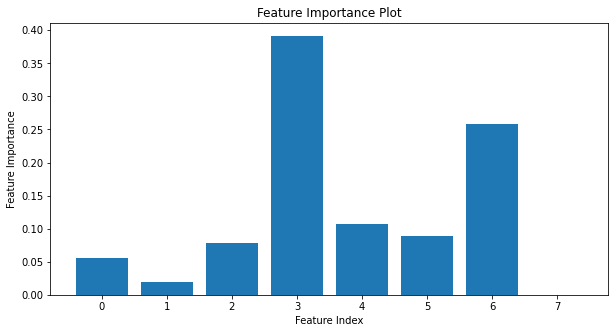

In [38]:
plt.figure(figsize=(10,5))
if hasattr(dummy_model, 'feature_importances_'):
    feature_importance = dummy_model.feature_importances_
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance Plot')
    plt.show()

In [44]:
#We will make a stratified sample 
_x, X_sample, _y, y_sample = train_test_split(X,y,test_size=0.1,random_state=0,stratify=y)

In [49]:
X_train_samp, X_test_samp, y_train_samp, y_test_samp = train_test_split(X_sample, y_sample, test_size=0.2, stratify=y_sample)

In [50]:
X_train_samp.shape, X_test_samp.shape

((509009, 8), (127253, 8))

In [82]:
max_components = X.shape[1]
f1_summary = {}
recall_summary = {}
feature_names = X.columns

for k in range(1, max_components):
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_new_train = selector.fit_transform(X_train_samp, y_train_samp)
    X_new_test = selector.transform(X_test_samp)
    
    # Get the names of the selected features
    selected_feature_names = [feature_names[i] for i in selector.get_support(indices=True)]
    
    # Train the dummy model on the selected features
    dummy_model.fit(X_new_train, y_train_samp)
    
    # Make predictions and calculate f1 score and recall score
    y_preds = dummy_model.predict(X_new_test)
    f1 = f1_score(y_test_samp, y_preds)
    recall = recall_score(y_test_samp, y_preds)
    
    # Store the f1, recall scores, and feature names in the summary dictionaries
    f1_summary[f"features[{k}]"] = {'f1_score': f1, 'selected_features': selected_feature_names}
    recall_summary[f"features[{k}]"] = {'recall_score': recall, 'selected_features': selected_feature_names}

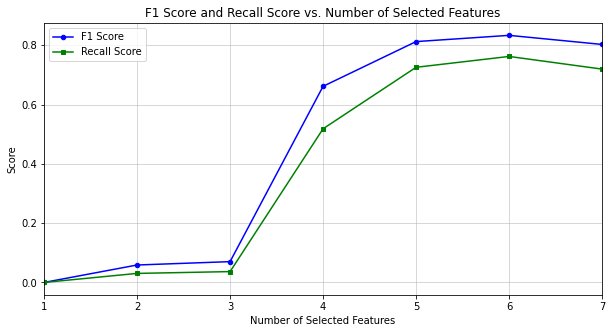

In [99]:
plt.figure(figsize=(10, 5))

# Plot F1 score
plt.plot(range(1, 8), [score['f1_score'] for score in f1_summary.values()], marker="o", ms=4.5, label="F1 Score", color='blue')

# Plot Recall score
plt.plot(range(1, 8), [score['recall_score'] for score in recall_summary.values()], marker="s", ms=4.5, label="Recall Score", color='green')

plt.xlabel("Number of Selected Features")
plt.ylabel("Score")
plt.title("F1 Score and Recall Score vs. Number of Selected Features")
plt.xlim(1, 7)
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [112]:
def get_feature_names(summary,K):
    for k,v in summary.items():
        if int(re.findall("\d",k)[0])==K:
            return v["selected_features"]

In [113]:
#Optimal performance is observed with a feature set of six elements (k=6). Recommend utilizing this subset for further analysis.
feature_names = get_feature_names(f1_summary,6)
print(f"features are: {feature_names}")

features are: ['step', 'type', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


In [117]:
#new features and labels
X_new = X.loc[:,feature_names]
X_new.shape, y.shape

((6362620, 6), (6362620,))

In [196]:
X_new.head()

,step,type,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,3,1.028310,0.923232,-0.914445,-0.964659
1,1,3,-0.305117,-0.317853,-0.914445,-0.964659
2,1,4,-0.845552,-0.710523,-0.914445,-0.964659
3,1,1,-0.845552,-0.710523,-0.820145,-0.964659
4,1,3,0.055501,-0.145828,-0.914445,-0.964659


Tuning and re-training 

In [159]:
for stats in model_summary:
    if stats["Model_name"]== "DecisionTreeClassifier":
        final_model = stats["Model"]
        print(final_model)

DecisionTreeClassifier()


In [160]:
#Splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X_new,y,test_size=0.3,random_state=0,stratify=y)

In [161]:
strK = StratifiedKFold(12)

In [162]:
f1_scores, recall_scores = [],[]
c = 1
for train_index, test_index in strK.split(X_train, Y_train):
    
    #batches
    x_train, y_train = X_train.iloc[train_index], Y_train.iloc[train_index]
    x_test, y_test = X_train.iloc[test_index], Y_train.iloc[test_index]
    
    #fitting and making batch wise predictions
    final_model.fit(x_train,y_train)
    y_preds = final_model.predict(x_test)
    
    #evaluation 
    f1s = f1_score(y_test, y_preds)
    rs = recall_score(y_test, y_preds)
    print(f"fold[{c}]: f1_score:{f1s} | recall_score:{rs}")
    c+=1
    f1_scores.append(f1s)
    recall_scores.append(rs)

fold[1]: f1_score:0.7913513513513514 | recall_score:0.7640918580375783
fold[2]: f1_score:0.7782426778242678 | recall_score:0.7766179540709812
fold[3]: f1_score:0.7879417879417878 | recall_score:0.791231732776618
fold[4]: f1_score:0.7750791974656811 | recall_score:0.7661795407098121
fold[5]: f1_score:0.8049029622063331 | recall_score:0.8225469728601252
fold[6]: f1_score:0.792332268370607 | recall_score:0.7766179540709812
fold[7]: f1_score:0.7966457023060797 | recall_score:0.7933194154488518
fold[8]: f1_score:0.7719298245614035 | recall_score:0.7807933194154488
fold[9]: f1_score:0.7970711297071131 | recall_score:0.7954070981210856
fold[10]: f1_score:0.8109243697478992 | recall_score:0.8041666666666667
fold[11]: f1_score:0.8152734778121774 | recall_score:0.824634655532359
fold[12]: f1_score:0.8206185567010309 | recall_score:0.8308977035490606


Evaluation 

In [163]:
#making predictions
y_preds = final_model.predict(X_test)

In [194]:
accuracy = accuracy_score(Y_test, y_preds)
precision = precision_score(Y_test, y_preds)
recall = recall_score(Y_test, y_preds)
f1 = f1_score(Y_test, y_preds)
print(f"recall score:{recall} | f1 score:{f1}\naccuracy_score:{accuracy} | precision_score:{precision}")

recall score:0.7905844155844156 | f1 score:0.7952643396611554
accuracy_score:0.9994745351233716 | precision_score:0.8


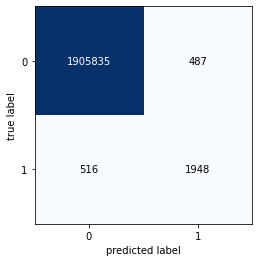

In [190]:
#confusion matrix
conf_matrix = confusion_matrix(Y_test,y_preds)
fig, axes = plot_confusion_matrix(conf_mat=conf_matrix)
plt.show()

<Figure size 864x360 with 0 Axes>

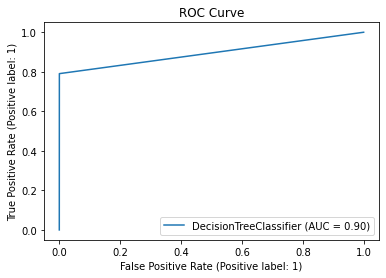

In [176]:
# 2. ROC Curve
plt.figure(figsize=(12, 5))
plot_roc_curve(final_model, X_test, Y_test)
plt.title('ROC Curve')
plt.show()

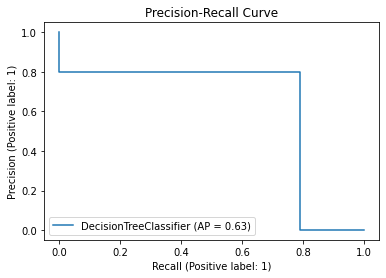

In [178]:
# 3. Precision-Recall Curve
plot_precision_recall_curve(final_model, X_test, Y_test)
plt.title('Precision-Recall Curve')
plt.show()

In [182]:
print(classification_report(Y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.80      0.79      0.80      2464

    accuracy                           1.00   1908786
   macro avg       0.90      0.90      0.90   1908786
weighted avg       1.00      1.00      1.00   1908786



Loading models

In [199]:
#all models with summary 
models_dict_path = os.path.join(models_dir, "models_dict.pkl")
with open(models_dict_path, "wb") as file:
        pickle.dump(model_summary, file)

In [198]:
#final model
final_model_path = os.path.join(models_dir, "final_model.pkl")
with open(final_model_path, "wb") as file:
        pickle.dump(final_model, file)